In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from sklearn.utils import resample
import random
from collections import defaultdict
from statistics import mean
from copy import deepcopy

# define a specific seed for reproductibility
seed=42

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

%matplotlib inline

---
# Data Analysis

In [2]:
df = pd.read_csv('./Train_Test_Network_dataset/NF-ToN-IoT-v2.csv.gz')

In [3]:
df['Attack'].unique()

array(['ransomware', 'Benign', 'xss', 'scanning', 'password', 'dos',
       'ddos', 'injection', 'mitm', 'backdoor'], dtype=object)

In [4]:
# create a dataframe with just the instances of benign and scanning traffic
df_scan = df[df['Attack'].isin(['Benign', 'scanning'])]
df_scan['Attack'].unique()

array(['Benign', 'scanning'], dtype=object)

In [5]:
del df

In [6]:
df_scan.drop('Attack', axis=1, inplace=True)

In [7]:
# Attack (1), Benign (0)
df_scan['Label'].value_counts() # this dataset contains ALL benign plus those with Scanning

0    6099469
1    3781419
Name: Label, dtype: int64

In [8]:
# according to paper these are the source IPs from Scanning attacks (Ground-truth)
scan_src_ip = ['192.168.1.30', '192.168.1.31', '192.168.1.32', '192.168.1.33', '192.168.1.38']

In [9]:
# Who are the targets of Scanning machines ?
# top targets of Scan, greater than 3k flow samples
top = df_scan[df_scan['IPV4_SRC_ADDR'].isin(scan_src_ip)]['IPV4_DST_ADDR'].value_counts().head(229).index

In [10]:
# which machines are targeting the Scanning machines ? (counter direction of flow)
#df_scan[df_scan['IPV4_DST_ADDR'].isin(scan_src_ip)]['IPV4_SRC_ADDR'].value_counts()

In [11]:
# filter dataframe for top Scanning IP destinations (considering Scanning traffic)
df_top = df_scan[df_scan['IPV4_DST_ADDR'].isin(top)]

In [12]:
# check the balance between scan and normal for top scan targets
# 0 is benign and 1 is attack (just Scanning)
target_balance = df_top[['IPV4_DST_ADDR', 'Label']]
target_balance = pd.get_dummies(target_balance, columns=['Label'])
#target_balance.groupby('IPV4_DST_ADDR').sum()

### Choose the feasible agents according to the amount of benign traffic (dst addr with both normal and scanning flow samples)

In [13]:
feasible_agents = ['192.168.1.1', '192.168.1.133', '192.168.1.152', '192.168.1.169', '192.168.1.180', '192.168.1.186', 
       '192.168.1.190', '192.168.1.193', '192.168.1.194', '192.168.1.195', '192.168.1.46', '192.168.1.49', '192.168.1.79']
df_top = df_top[df_top['IPV4_DST_ADDR'].isin(feasible_agents)]

### Check the balance between scanning and normal for top scanning targets

In [14]:
target_balance = df_top[['IPV4_DST_ADDR', 'Label']]
target_balance = pd.get_dummies(target_balance, columns=['Label'])
# Attack (1), Benign (0)
target_balance.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
192.168.1.1,63982.0,4076.0
192.168.1.133,41907.0,26437.0
192.168.1.152,282044.0,283228.0
192.168.1.169,331910.0,398356.0
192.168.1.180,721573.0,566956.0
192.168.1.186,330606.0,126448.0
192.168.1.190,623891.0,338422.0
192.168.1.193,336907.0,162393.0
192.168.1.194,296947.0,231666.0


In [15]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']
df_hist = df_top.loc[:, ~df_top.columns.isin(remove_columns)]
df_hist.describe()

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8150567.0,3106699.0,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06,8.150567e+06
mean,6.162411e+02,4.169987e+00,3.590866e+02,1.969957e+00,9.114937e+00,2.951397e+00,7.091086e+00,1.623337e+05,1.858105e+00,9.196641e-01,5.093827e+00,5.104029e+00,7.435848e+01,4.584149e+01,1.645922e+01,7.435848e+01,inf,inf,4.610571e+00,8.258444e-03,1.495425e+00,3.037089e-03,7.484637e+05,9.232642e+05,1.746721e+02,1.310197e-01,1.666024e-01,1.364593e-01,2.738570e-01,3.308111e+03,1.609268e+03,6.946378e+00,2.713370e-02,1.277843e+03,1.279969e-01,7.454688e+03,9.525791e-02,3.545007e-01
std,2.049792e+05,6.249247e+02,9.476114e+04,3.589538e+02,1.009639e+01,5.193408e+00,9.862930e+00,8.190545e+05,1.497845e+02,1.207256e+02,1.983612e+01,1.988213e+01,1.991576e+02,2.181555e+01,2.173421e+01,1.991576e+02,NaN,NaN,3.891532e+03,6.677792e+00,5.448291e+02,9.781101e-01,6.648798e+06,1.315136e+07,4.575794e+03,3.304372e+01,2.958746e+01,2.759942e+01,1.353707e+02,7.461433e+03,8.472410e+03,5.405634e+02,2.111559e+00,7.424895e+03,1.562982e+00,6.601468e+04,6.328241e+00,4.783618e-01
min,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,28.0,28.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.000000e+01,0.000000e+00,4.400000e+01,44.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.400000e+01,0.000000e+00,4.400000e+01,44.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.800000e+01,1.000000e+00,4.000000e+01,1.000000e+00,2.200000e+01,2.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,4.800000e+01,4.000000e+01,4.800000e+01,48.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.840000e+05,3.200000e+05,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.096000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000

---
# Single repository with the data from all agents

In [16]:
df_top['IPV4_DST_ADDR'].unique()

array(['192.168.1.152', '192.168.1.193', '192.168.1.190', '192.168.1.1',
       '192.168.1.180', '192.168.1.49', '192.168.1.194', '192.168.1.46',
       '192.168.1.186', '192.168.1.195', '192.168.1.169', '192.168.1.133',
       '192.168.1.79'], dtype=object)

In [17]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']
df_top.drop(remove_columns, axis=1, inplace=True)

In [18]:
df_top.head()

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
1,1600,40,35741,65,24,16,24,4294952,15,15,128,128,1286,40,40,1286,1600.0,35741.0,0,0,0,0,800000,17864000,47,3,30,19,6,16425,237,0,0,0,0,0,0,0
2,212,2,0,0,0,0,0,0,0,0,64,64,106,106,0,106,212.0,NaN,0,0,0,0,1696000,0,2,0,0,0,0,0,0,771,3,0,0,0,0,0
6,318,3,0,0,0,0,0,0,0,0,64,64,106,106,0,106,318.0,NaN,0,0,0,0,2544000,0,3,0,0,0,0,0,0,771,3,0,0,0,0,0
11,318,3,0,0,0,0,0,0,0,0,64,64,106,106,0,106,318.0,NaN,0,0,0,0,2544000,0,3,0,0,0,0,0,0,771,3,0,0,0,0,0
13,29136,50,1200,30,24,24,16,0,0,0,64,64,1500,40,40,1500,29136.0,1200.0,0,0,0,0,233088000,9600000,37,4,17,15,7,237,16425,0,0,0,0,0,0,0


---
# Training generic Logistic Regression model on full dataset as Baseline

In [19]:
def preprocess(X):
    cols = X.select_dtypes(include=[np.float64]).columns
    X[cols] = X[cols].astype(np.float32)

    X.fillna(0, inplace=True)
    X.replace(np.inf, 9999, inplace=True)
    
    return X

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve

X = df_top.drop(columns = ["Label"])
y = df_top.Label

X = preprocess(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
parameters = {}
    
prep = StandardScaler() 
X_train = prep.fit_transform(X_train)
clf.fit(X_train, y_train)
    
X_test = prep.transform(X_test) 
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1] # for ROC curve, get just for positive class "1"
    
score = f1_score(y_test, y_pred, average="binary") # binary only report results for the class 1 (pos_label)
        
print(set(y_test), set(y_pred), "{:.2f}".format(score))

results = {}
results["f1-score"] = score
results["accuracy"] = balanced_accuracy_score(y_test, y_pred)
results["precision"] = precision_score(y_test, y_pred, average="binary")
results["recall"] =  recall_score(y_test, y_pred, average="binary")
results["auc"] = roc_auc_score(y_test, y_pred)
results["fpr"], results["tpr"], results["thresholds"] = roc_curve(y_test, y_proba)
results["%benign"] = float("{:.3f}".format(sum(y==0)/len(y)))
results["%scan"] = float("{:.3f}".format(sum(y==1)/len(y)))
results["total_samples"] = len(y)

{0, 1} {0, 1} 0.93


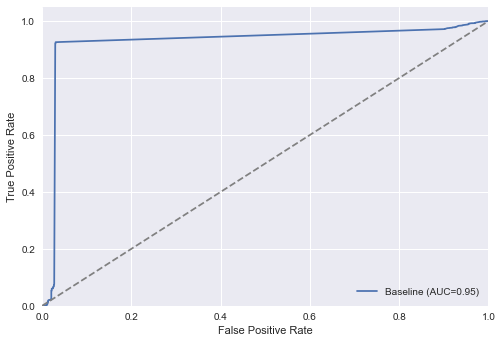

In [28]:
plt.style.use('seaborn')
plt.figure()

fpr, tpr, thresholds = results["fpr"], results["tpr"], results["thresholds"]
AUC = results["auc"]
    
plt.plot(fpr, tpr, label="{} (AUC={:.2f})".format("Baseline", AUC))

plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")


In [29]:
results

{'f1-score': 0.9345276630229752,
 'accuracy': 0.9476774770794261,
 'precision': 0.9432912933665704,
 'recall': 0.9259253704654395,
 'auc': 0.9476774770794261,
 'fpr': array([0.00000000e+00, 7.94497566e-04, 8.25542527e-04, ...,
        9.99975291e-01, 9.99975291e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 0.00000000e+00, 2.42266228e-05, ...,
        9.99996539e-01, 9.99997693e-01, 1.00000000e+00]),
 'thresholds': array([2.0000000e+000, 1.0000000e+000, 1.0000000e+000, ...,
        2.9929647e-286, 1.2900370e-297, 0.0000000e+000]),
 '%benign': 0.645,
 '%scan': 0.355,
 'total_samples': 8150567}